In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import pickle
import librosa
import os
import soundfile as sf
from IPython.display import Audio, display
plt.style.use('default')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_folder = r'/content/drive/MyDrive/'

In [ ]:
#load mnist data
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

#normalizing
x_train = x_train/255
x_test = x_test/255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
#reshaping input 28 x 28 to 784 dimensional vector for train and test
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

In [ ]:
#printing shape after reshaping
print(f"training shape : {x_train.shape}")
print(f"training shape : {x_test.shape}")

training shape : (60000, 784)
training shape : (10000, 784)


# Baseline Model

In [ ]:
#baseline model with 5 layers
baseline_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024, input_shape=(28*28,),activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation=None, kernel_initializer='he_normal') ])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=40, restore_best_weights=True)

baseline_model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

baseline_his = baseline_model.fit(x=x_train, y=y_train, batch_size = 1024, epochs=200,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/200
59/59 [==============================] - 3s 18ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 0.9519
Epoch 2/200
59/59 [==============================] - 1s 13ms/step - loss: 0.1140 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.0965 - val_sparse_categorical_accuracy: 0.9706
Epoch 3/200
59/59 [==============================] - 1s 13ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.0806 - val_sparse_categorical_accuracy: 0.9767
Epoch 4/200
59/59 [==============================] - 1s 13ms/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9774
Epoch 5/200
59/59 [==============================] - 1s 13ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0654 - val_sparse_categorical_accuracy: 0.9801
Epoch 6/200
59/59 [==============================] - 1s 13ms/step - loss: 0.0154 - sparse_categorica

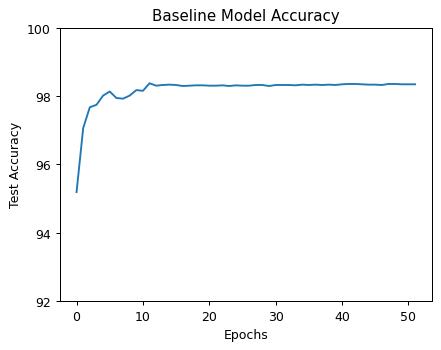

In [ ]:
baseline_acc = [acc*100 for acc in baseline_his.history['val_sparse_categorical_accuracy']]
plt.figure(figsize=(5, 4),dpi=90)
plt.plot(baseline_acc)
plt.yticks(np.array([92,94,96,98,100]))
plt.title('Baseline Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
#save weights
file_name = data_folder+'baseline_p1.h5'
baseline_model.save_weights(file_name)

#save model history
history_dict = baseline_his.history

# Save it to a JSON file
with open(data_folder+'baseline_p1_history.json', 'w') as file:
    json.dump(history_dict, file)

In [ ]:
#define model to load weights
#baseline model with 5 layers
baseline_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1024, input_shape=(28*28,),activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation=None, kernel_initializer='he_normal') ])

# Define early stopping based
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=40, restore_best_weights=True)

baseline_model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
baseline_model.load_weights(data_folder+'baseline_p1.h5')

with open(data_folder+'baseline_p1_history.json') as file:
    baseline_history = json.load(file)

In [ ]:
#SVD on weights
usv_values = []
baseline_biases = []
#iterate through all layers except the last layer
for layer in baseline_model.layers[:-1]:
  #get weights and bias
  W,bias = layer.get_weights()
  #svd
  s,u,v = tf.linalg.svd(W)
  usv_values.append((u,s,v))
  baseline_biases.append(bias)

In [ ]:
D_values = [10,20,50,100,200,1024]

In [ ]:
#Define custom SVD layer with U,S and V matrices
class SVDLayer(tf.keras.layers.Layer):
  def __init__(self,U,S,V,D,bias):
    super().__init__()
    self.U = tf.keras.initializers.constant(U)
    self.S = tf.keras.initializers.constant(S)
    self.V = tf.keras.initializers.constant(V)
    self.D = D
    self.bias = tf.keras.initializers.constant(bias)

  #build U,S and V
  def build(self,input_shape):
    self.U = self.add_weight(shape=[input_shape[-1],self.D],initializer = self.U)
    self.S= self.add_weight(shape=[self.D,],initializer = self.S)
    self.V = self.add_weight(shape= [self.D, 1024],initializer = self.V)
    self.bias = self.add_weight(shape=[1024,],initializer=self.bias)

  #feed forward
  def call(self,x):
    v_l = tf.linalg.diag(self.S)@self.V
    W_hat = self.U@v_l
    return tf.nn.relu(tf.nn.bias_add(x@W_hat, self.bias))



In [ ]:
d_accuracies = []

model_params = []
#iterate through D values
for d in D_values:
  layer_params = []
  total_params = 0
  #define input tensor with shape
  input_tensor = tf.keras.layers.Input(shape=(784,))
  x = input_tensor
  #iterate through 5 dense layers
  for idx in range(5):
    #when D = Dfull, make d = 784 for first layer
    if d==1024 and idx==0:
      d_hat = 784
    else:
      d_hat = d

    u,s,v = usv_values[idx]
    u = u[:,:d_hat]
    s = s[:d_hat]
    v = tf.transpose(v[:,:d_hat])
    bias = baseline_biases[idx]
    #build svd layer
    x = SVDLayer(u,s,v,d_hat,bias)(x)

    #calculate layer params
    #for first layer
    if idx==0:
      curr_params = (784*d_hat) + d_hat + (d_hat*1024) + 1024 #bias
    else:
      curr_params = (1024*d_hat) + d_hat + (d_hat*1024) + 1024 #bias

    layer_params.append(curr_params)
    total_params += curr_params


  #build last layer
  x = tf.keras.layers.Dense(10)(x)
  last_layer_params = 1024*10 + 10

  layer_params.append(last_layer_params)
  total_params += last_layer_params

  model_params.append((layer_params,total_params))
  svd_model = tf.keras.models.Model(inputs=input_tensor,outputs=x)

  svd_model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
                          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  #set last layer weights
  svd_model.layers[-1].set_weights(baseline_model.layers[-1].get_weights())

  print(f'Model Params with D={d}:')
  print(svd_model.summary())
  print('\n')

  #calculate test accuracy
  loss, acc = svd_model.evaluate(x_test, y_test, verbose=0)

  d_accuracies.append(acc*100)

Model Params with D=10:
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 svd_layer_30 (SVDLayer)     (None, 1024)              19114     
                                                                 
 svd_layer_31 (SVDLayer)     (None, 1024)              21514     
                                                                 
 svd_layer_32 (SVDLayer)     (None, 1024)              21514     
                                                                 
 svd_layer_33 (SVDLayer)     (None, 1024)              21514     
                                                                 
 svd_layer_34 (SVDLayer)     (None, 1024)              21514     
                                                                 
 dense_12 (Dense)            (None,

In [ ]:
#baseline params
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 5012490 (19.12 MB)
Trainable params: 50124

In [ ]:
print('Model Paramters')
print('Layer      D=10 Model    D=20 Model    D=50 Model      D=100 Model    D=200 Model   D=1024 Model')
for idx in range(6):
  print(f'''Layer {idx+1}      {model_params[0][0][idx]}        {model_params[1][0][idx]}          {model_params[2][0][idx]}           {model_params[3][0][idx]}        {model_params[4][0][idx]}        {model_params[5][0][idx]}''')
print('\n')
print(f'''Total      {model_params[0][1]}        {model_params[1][1]}          {model_params[2][1]}           {model_params[3][1]}        {model_params[4][1]}        {model_params[5][1]}''')

Model Paramters
Layer      D=10 Model    D=20 Model    D=50 Model      D=100 Model    D=200 Model   D=1024 Model
Layer 1      19114        37204          91474           181924        362824        1419280
Layer 2      21514        42004          103474           205924        410824        2099200
Layer 3      21514        42004          103474           205924        410824        2099200
Layer 4      21514        42004          103474           205924        410824        2099200
Layer 5      21514        42004          103474           205924        410824        2099200
Layer 6      10250        10250          10250           10250        10250        10250


Total      115420        215470          515620           1015870        2016370        9826330


### Network Parameters
- For the baseline model, parameters for any layer are calculated as (input_layer_features * units) + units (for bias).

 - For compressed models, the parameter calculations are as follows:
    - First layer: (784 * D) + D + (D*1024) + 1024 - here D is 784 when D=1024 else D=D
    - Other layers except last layer: (1024 * D) + D + (D*1024) + 1024
    - Last layer: (1024 * 10) + 10
    - In above expressions, first term is U, second is S, third is V and fourth is the bias.


- From the above table and the previous cell (from model summaries), it's evident that the number of parameters in models with smaller D values is just a fraction of the total parameters in the baseline model. This results in a significant reduction in model size, typically measured in kilobytes (KB) to less than 5 megabytes (MB) (for D=10 to D=100) when compared with baseline model which takes 19MB . This demonstrates a substantial level of network compression, albeit with a trade-off in accuracy.

- Accuracies are presented below, and it's observed that when D=10, accuracy is lower, but as D value increases, accuracy approaches the baseline accuracy, indicating that larger D values can mitigate the trade-off in accuracy.


Baseline Accuracy: 98.34%
D=10 Accuracy: 28.99%
D=20 Accuracy: 39.36%
D=50 Accuracy: 56.14%
D=100 Accuracy: 73.44%
D=200 Accuracy: 89.22%
D=1024 Accuracy: 98.37%


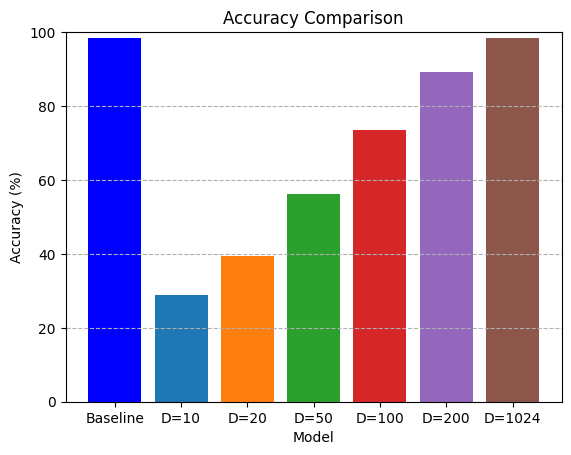

In [ ]:
#Report Accuracies
# Baseline Accuracy
baseline_accuracy = 100 * baseline_history['val_sparse_categorical_accuracy'][-1]
print(f"Baseline Accuracy: {baseline_accuracy:.2f}%")

# Plot baseline accuracy
plt.bar("Baseline", baseline_accuracy, color='blue')

for D, acc in zip(D_values, d_accuracies):
    print(f"D={D} Accuracy: {acc:.2f}%")
    # Plot accuracy for each D value
    plt.bar(f"D={D}", acc)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()

# Training Compressed Network using SVD

In [ ]:
#create customer feedforward layer
class FeedForwardSVDLayer(tf.keras.layers.Layer):
  def __init__(self,units,baseline_weights,d):
    super().__init__()
    self.units = units
    self.d = d
    self.W = tf.keras.initializers.Constant(baseline_weights[0])
    self.b = tf.keras.initializers.Constant(baseline_weights[1])

  #build weights
  def build(self,input_shape):
    self.kernel = self.add_weight(shape=[input_shape[-1],self.units],initializer= self.W)
    self.bias = self.add_weight(shape =(self.units,),initializer = self.b)

  #feed forward
  def call(self,x):
    #factorize weights or compress
    s,u,v = tf.linalg.svd(self.kernel)
    #compress and reconstruct the matrix
    u = u[:,:self.d]
    s = tf.linalg.diag(s[:self.d])
    vt = tf.transpose(v[:,:self.d])
    self.Wc = u@s@vt
    #return output
    return tf.nn.relu(tf.nn.bias_add(x@self.Wc, self.bias))

  @property
  def trainable_weights(self):
      # Override to include compressed weights for gradient calculations
      return [self.Wc, self.bias]

In [ ]:
# Define and compile the model
ff_svd_model = tf.keras.models.Sequential()
ff_svd_model.add(tf.keras.layers.InputLayer(input_shape=(784,)))

for layer in baseline_model.layers[:-1]:
  ff_svd_model.add(FeedForwardSVDLayer(1024,layer.get_weights(),20))

ff_svd_model.add(tf.keras.layers.Dense(10))
ff_svd_model.layers[-1].set_weights(baseline_model.layers[-1].get_weights())

ff_svd_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

ff_svd_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feed_forward_svd_layer_45   (None, 1024)              803840    
 (FeedForwardSVDLayer)                                           
                                                                 
 feed_forward_svd_layer_46   (None, 1024)              1049600   
 (FeedForwardSVDLayer)                                           
                                                                 
 feed_forward_svd_layer_47   (None, 1024)              1049600   
 (FeedForwardSVDLayer)                                           
                                                                 
 feed_forward_svd_layer_48   (None, 1024)              1049600   
 (FeedForwardSVDLayer)                                           
                                                                 
 feed_forward_svd_layer_49   (None, 1024)            

In [ ]:
#check if accuracy is same as baseline model with D=20
ff_svd_model.evaluate(x_test,y_test,batch_size = 10000)

#It's same - 39.36%

1/1 [==============================] - 4s 4s/step - loss: 1.8326 - accuracy: 0.3936


[1.832603096961975, 0.3935999870300293]

In [ ]:
#Define loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.0001)

#get original kernel and bias
original_w = []
for layer in ff_svd_model.layers:
  original_w.append(layer.kernel)
  original_w.append(layer.bias)

#training loop
batch_size = 1024
for epoch in range(20):
  for i in range(0, len(x_train), batch_size):
        # print(i)
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        with tf.GradientTape() as tape:
            predictions = ff_svd_model(x_batch)
            loss = loss_fn(y_batch, predictions)

        # Compute gradients w.r.t compressed weights (as trainable variables are overwritten by Wc and bias)
        gradients = tape.gradient(loss, ff_svd_model.trainable_variables)

        #apply gradients to original weights
        optimizer.apply_gradients(zip(gradients, original_w))

        del tape

  print(f'Epoch :{epoch+1} ======>')
  val_loss,val_acc = ff_svd_model.evaluate(x_test,y_test,batch_size=10000)

Epoch :1 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.2662 - accuracy: 0.9199
Epoch :2 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1909 - accuracy: 0.9420
Epoch :3 ======>
1/1 [==============================] - 4s 4s/step - loss: 0.1704 - accuracy: 0.9491
Epoch :4 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1529 - accuracy: 0.9551
Epoch :5 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1398 - accuracy: 0.9577
Epoch :6 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1339 - accuracy: 0.9598
Epoch :7 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1455 - accuracy: 0.9546
Epoch :8 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1163 - accuracy: 0.9634
Epoch :9 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1118 - accuracy: 0.9653
Epoch :10 ======>
1/1 [==============================] - 3s 3s/step - loss: 0.1290 - accura

In [ ]:
#get test accuracy
ff_svd_val_loss,ff_svd_val_acc = ff_svd_model.evaluate(x_test,y_test,batch_size=10000,verbose=0)
print(f'Model accuracy- running SVD at every epoch : {ff_svd_val_acc*100:.2f}%')

Model accuracy- running SVD at every epoch : 97.31%


- By performing SVD at every epoch during training, accuracy of 97.31% is achieved. This accuracy is very close to the baseline model's accuracy of 98.34%, with only a minor reduction of 1.03%. This demonstrates that competitive accuracy can be achieved by factorizing the weight matrices at each epoch.
- By doing this, we can do SVD on the original W and store only factorized weights which will have same accuracy achieving network compression which requires very less memory.